# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score , auc, roc_curve
import torch as tc
from scipy import stats
from scipy.stats import norm, shapiro

# Read data

In [2]:
data = pd.read_csv("/kaggle/input/oranges-vs-grapefruit/citrus.csv")
data = pd.DataFrame(data)
data

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
...,...,...,...,...,...,...
9995,grapefruit,15.35,253.89,149,77,20
9996,grapefruit,15.41,254.67,148,68,7
9997,grapefruit,15.59,256.50,168,82,20
9998,grapefruit,15.92,260.14,142,72,11


# Data Description and Correlation

In [3]:
data.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


/tmp/ipykernel_23/3536763073.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr(method = 'pearson')


<Axes: >

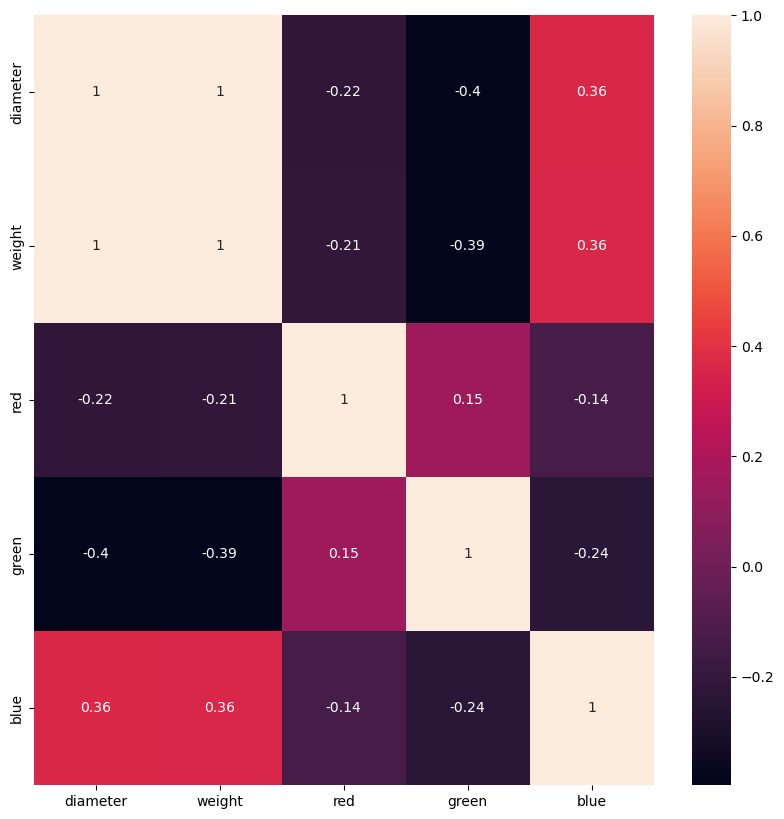

In [5]:
# correlation between features using pearson's correlation coefficient 
cor = data.corr(method = 'pearson')
plt.figure(figsize = (10,10))
sns.heatmap(cor, annot=True)

# Plotting data scattered

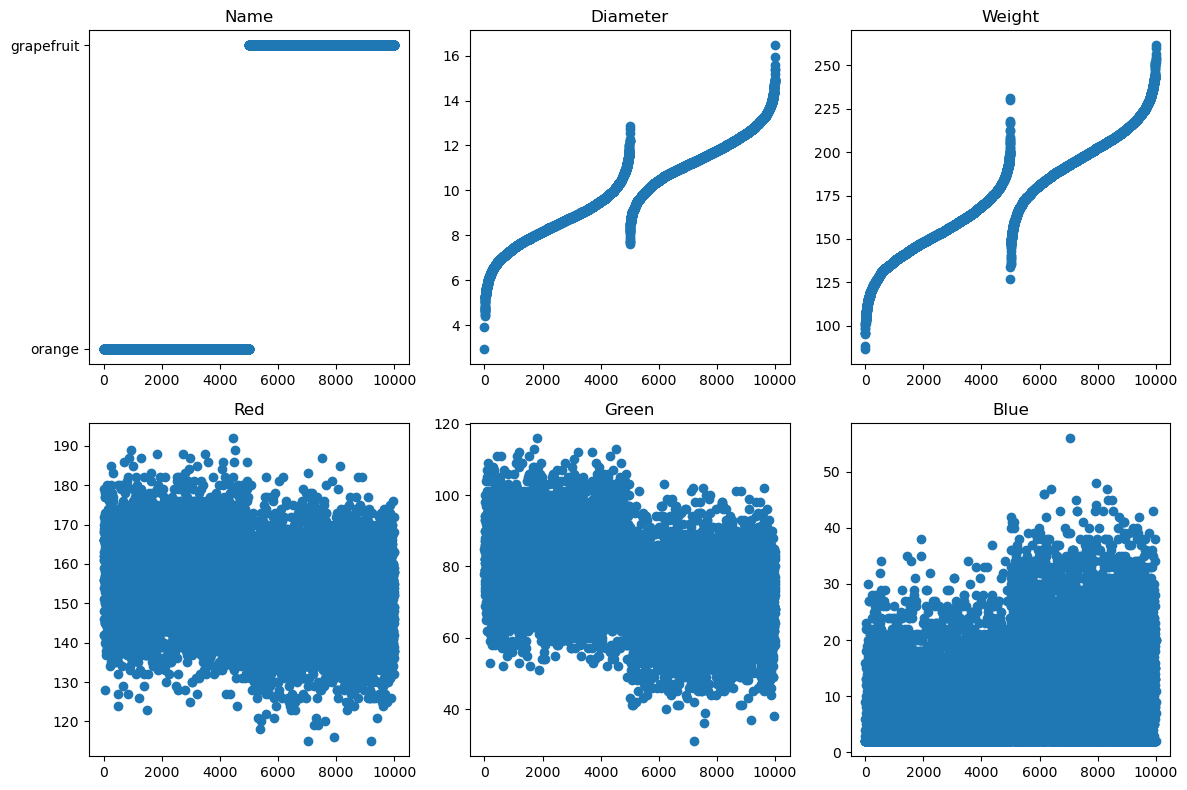

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Plot on the first subplot
axs[0, 0].scatter(data.index, data['name'])
axs[0, 0].set_title('Name')

# Plot on the second subplot
axs[0, 1].scatter(data.index, data['diameter'])
axs[0, 1].set_title('Diameter')

# Plot on the third subplot
axs[0, 2].scatter(data.index, data['weight'])
axs[0, 2].set_title('Weight')

# Plot on the fourth subplot
axs[1, 0].scatter(data.index, data['red'])
axs[1, 0].set_title('Red')

# Plot on the fifth subplot
axs[1, 1].scatter(data.index, data['green'])
axs[1, 1].set_title('Green')

# Plot on the sixth subplot
axs[1, 2].scatter(data.index, data['blue'])
axs[1, 2].set_title('Blue')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

# Transform Catagorical data into Numerical data
#### Convert the Column **Name** into Orange = 0 ,  GrapeFruit = 1

In [7]:
# Create a dictionary to map the values in the "name" column
name_mapping = {"orange": 0, "grapefruit": 1}

# Use the map() function to replace the values in the "name" column with the mapped values
data["name"] = data["name"].map(name_mapping)

# The "name" column now contains the mapped values
data

,name,diameter,weight,red,green,blue
0,0,2.96,86.76,172,85,2
1,0,3.91,88.05,166,78,3
2,0,4.42,95.17,156,81,2
3,0,4.47,95.60,163,81,4
4,0,4.48,95.76,161,72,9
...,...,...,...,...,...,...
9995,1,15.35,253.89,149,77,20
9996,1,15.41,254.67,148,68,7
9997,1,15.59,256.50,168,82,20
9998,1,15.92,260.14,142,72,11


## Calculate a set of descriptive statistics
### $ Mean, STD , Variance $

In [8]:
# Create a dictionary to store the statistical measures
stat_dict = {
    "name":[],
    "diameter": [],
    "weight": [],
    "red": [],
    "green": [],
    "blue": []
}

# Iterate over the columns in the dataset
for label in data.columns:
    # Calculate statistical measures and append them to the respective list in stat_dict
    stat_dict[label].extend([np.mean(data[label]), np.var(data[label]), np.std(data[label])])

print(stat_dict)


{'name': [0.5, 0.25, 0.5], 'diameter': [9.975685, 3.7937155107750002, 1.9477462644746621], 'weight': [175.050792, 853.262576972736, 29.210658619290598], 'red': [153.8478, 108.83563515999997, 10.43243189098304], 'green': [76.0106, 137.07368764, 11.707847267538128], 'blue': [11.3632, 82.09848576, 9.060821472692197]}


# Distribution of data before **standarization**

<Axes: >

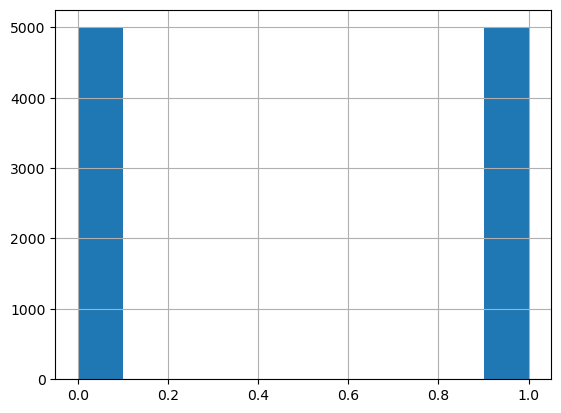

In [9]:
data["name"].hist()

<Axes: xlabel='blue', ylabel='Count'>

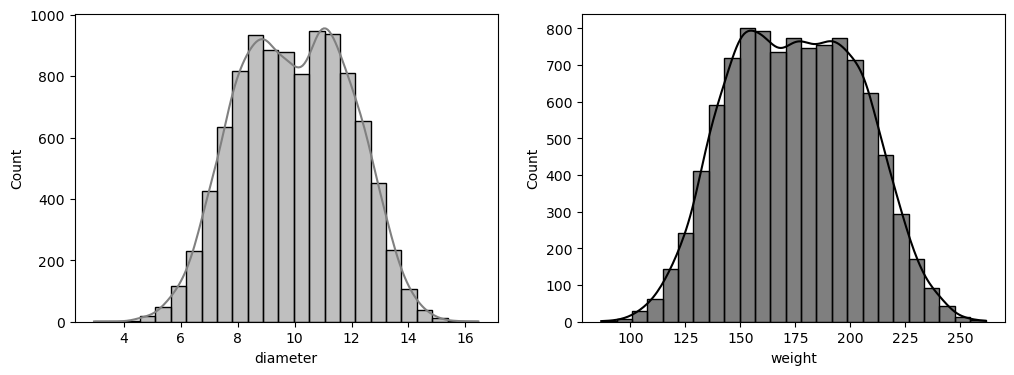

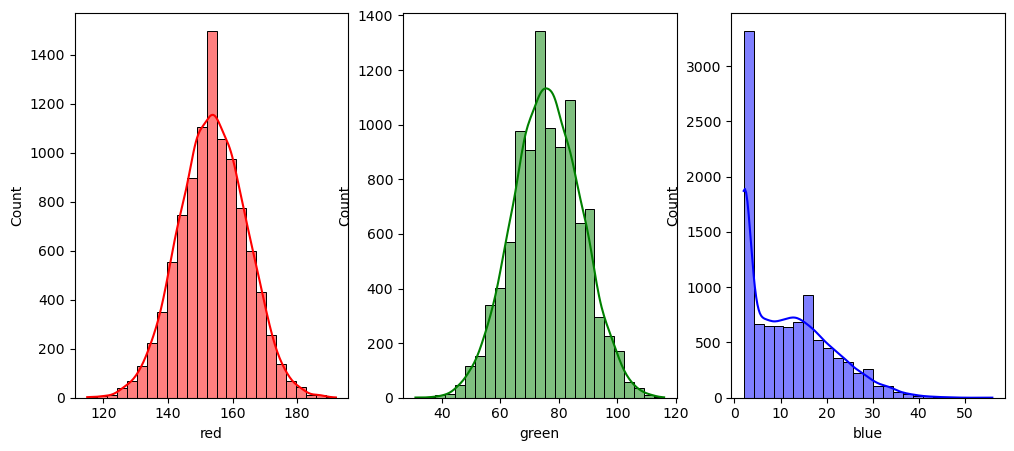

In [10]:
# Create subplots with 1 row and 2 columns for the first figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Create subplots with 1 row and 3 columns for the second figure
fig, axs2 = plt.subplots(1, 3, figsize=(12, 5))

# Plot histogram of the 'diameter' feature with kernel density estimation
sns.histplot(data, x="diameter", kde=True, color='grey', ax=axs[0], bins=25)

# Plot histogram of the 'weight' feature with kernel density estimation
sns.histplot(data, x="weight", kde=True, color='black', ax=axs[1], bins=25)

# Plot histogram of the 'red' feature with kernel density estimation
sns.histplot(data, x="red", kde=True, color='r', ax=axs2[0], bins=25)

# Plot histogram of the 'green' feature with kernel density estimation
sns.histplot(data, x="green", kde=True, color='green', ax=axs2[1], bins=25)

# Plot histogram of the 'blue' feature with kernel density estimation
sns.histplot(data, x="blue", kde=True, color='b', ax=axs2[2], bins=25)

***************************************************


# Removing Outliers using interquartile Range
### $\text {Upper Quartile} (Q3) = \text{{75th percentile}}$

### $\text {Lower Quartile} (Q1) = \text{{25th percentile}}$

### $ IQR = Q3 - Q1 $

## Removing Duplicates

In [11]:
for label in data.columns:
    # Sort the column values
    sorted_col = data[label].sort_values()

    # Calculate the quartiles and IQR
    Q1 = sorted_col.quantile(0.25)
    Q3 = sorted_col.quantile(0.75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers outside the bounds in-place
    data[label] = data[label][(data[label] >= lower_bound) & (data[label] <= upper_bound)]

# Print the dataset with outliers removed in-place

# remove duplicates and NaN values
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9868 entries, 2 to 9998
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      9868 non-null   int64  
 1   diameter  9868 non-null   float64
 2   weight    9868 non-null   float64
 3   red       9868 non-null   float64
 4   green     9868 non-null   float64
 5   blue      9868 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 539.7 KB


# Standardize data using **Z-Score** method 
## $$ Z = \frac{{X - \mu}}{{\sigma}}  $$

In [12]:
# Select the columns to be standardized
columns_to_standardize = ['diameter', 'weight', 'red', 'green', 'blue']

# Standardize the selected columns
for column in columns_to_standardize:
    mean = stat_dict[column][0]
    std = stat_dict[column][2]
    data[column] = (data[column] - mean) / std

data

,name,diameter,weight,red,green,blue
2,0,-2.852366,-2.734645,0.206299,0.426159,-1.033372
3,0,-2.826695,-2.719925,0.877283,0.426159,-0.812642
4,0,-2.821561,-2.714447,0.685574,-0.342557,-0.260815
5,0,-2.765086,-2.711024,-1.135670,2.049002,-1.033372
6,0,-2.739415,-2.639817,0.206299,0.767810,-1.033372
...,...,...,...,...,...,...
9994,1,2.661699,2.690429,-1.710800,-0.000905,0.953203
9995,1,2.759248,2.698988,-0.464686,0.084507,0.953203
9996,1,2.790053,2.725690,-0.560540,-0.684208,-0.481546
9997,1,2.882467,2.788339,1.356558,0.511571,0.953203


********************************************************

# Hypotesis testing for Normality 

## 1. Test Population Skewness
  * ### Skewness is a number that indicates to what extent a variable is asymmetrically distributed.

In [13]:
skewness_diameter = stats.skew(data["diameter"], bias=False)
skewness_weight = stats.skew(data["weight"], bias=False)
skewness_red = stats.skew(data["red"], bias=False)
skewness_green = stats.skew(data["green"], bias=False)
skewness_blue = stats.skew(data["blue"], bias=False)

print("Population skewness for Diameter:", skewness_diameter)
print("Population skewness for Weight:", skewness_weight)
print("Population skewness for Red:", skewness_red)
print("Population skewness for Green:", skewness_green)
print("Population skewness for Blue:", skewness_blue)

Population skewness for Diameter: -0.022560939830936093
Population skewness for Weight: 0.027862546544979824
Population skewness for Red: -0.006605298894416133
Population skewness for Green: -0.000906774340579392
Population skewness for Blue: 0.7404623334089714


## 2. Test Population Kurtosis
   * ### kurtosis refers to the “peakedness”of the distribution for a quantitative variable.

In [14]:
# Calculate population kurtosis for each feature
kurtosis_diameter = stats.kurtosis(data["diameter"], bias=False)
kurtosis_weight = stats.kurtosis(data["weight"], bias=False)
kurtosis_red = stats.kurtosis(data["red"], bias=False)
kurtosis_green = stats.kurtosis(data["green"], bias=False)
kurtosis_blue = stats.kurtosis(data["blue"], bias=False)

print("Population kurtosis for Diameter:", kurtosis_diameter)
print("Population kurtosis for Weight:", kurtosis_weight)
print("Population kurtosis for Red:", kurtosis_red)
print("Population kurtosis for Green:", kurtosis_green)
print("Population kurtosis for Blue:", kurtosis_blue)

Population kurtosis for Diameter: -0.689374793559558
Population kurtosis for Weight: -0.7073309226453
Population kurtosis for Red: -0.2796530740766099
Population kurtosis for Green: -0.2961648668793653
Population kurtosis for Blue: -0.3235327865160835


## 3. Shapiro-Wilk test

#### it superimposes a normal curve over the observed distribution. <br/> It then computes which percentage of our sample overlaps with it: a similarity percentage.
### The **null hypothesis** for the Shapiro-Wilk test is:
   * #### a variable is normally distributed in some population
   * #### reject the null hypothesis if p < 0.05.
   
### The **alternative hypothesis** for the Shapiro-Wilk test is:
   * #### a variable is not normally distributed

In [15]:
def calculate_shapiro_wilk_coefficients(n):
    # Calculate the quantiles for the Shapiro-Wilk test statistic
    q = stats.norm.ppf((np.arange(1, n + 1) - 0.375) / (n + 0.25))

    # Calculate the sum of squared quantiles
    sum_squared_q = np.sum(q ** 2)

    # Calculate the scaling factor
    scaling_factor = 1 / np.sqrt(n)

    # Calculate coefficient a_n
    a_n = -2.706056 * scaling_factor ** 5 + 4.434685 * scaling_factor ** 4 - 2.07119 * scaling_factor ** 3 - 0.147981 * scaling_factor ** 2 + 0.221157 * scaling_factor + q[n - 1] * sum_squared_q ** (-0.5)

    # Calculate coefficient a_n_1
    a_n_1 = -3.582633 * scaling_factor ** 5 + 5.682633 * scaling_factor ** 4 - 1.752461 * scaling_factor ** 3 - 0.293762 * scaling_factor ** 2 + 0.042981 * scaling_factor + q[n - 2] * sum_squared_q ** (-0.5)

    # Calculate the epsilon value
    epsilon = (sum_squared_q - 2 * q[n - 1] ** 2 - 2 * q[n - 2] ** 2) / (1 - 2 * a_n ** 2 - 2 * a_n_1 ** 2)

    # Calculate the adjusted quantiles
    adjusted_q = q / np.sqrt(epsilon)

    # Update the first two adjusted quantiles
    adjusted_q[0] = -a_n
    adjusted_q[1] = -a_n_1

    return np.array(adjusted_q)

## Calculate the Test Statistic (W) from the shapiro-wilk coefficients using this Formula:

## $$W = \frac{{\left(\sum_{i} a_i \cdot x_i\right)^2}}{{\sum_{i} (x_i - \bar{x})^2}}$$


In [16]:
def shapiro_wilk_test(data):
    # Sort the data in ascending order
    sorted_data = np.sort(data)
    n = len(sorted_data)
    
    # Calculate Shapiro-Wilk coefficients
    coefficients = calculate_shapiro_wilk_coefficients(n)
    
    # Calculate the sample mean
    mean = np.mean(sorted_data)
    
    b = 0.0
    for i in range(0, int(n / 2)):
        # Calculate the W statistic numerator
        b += coefficients[i] * (sorted_data[n - i - 1] - sorted_data[i])
    b *= -1
    
    # Calculate the sum of squares
    sum_squares = np.sum((sorted_data - mean) ** 2)
    
    # Calculate the W statistic
    W = b ** 2 / sum_squares
    
    # Calculate the parameters for the W statistic transformation
    m = 0.0038915 * (np.log(n)) ** 3 - 0.083751 * (np.log(n)) ** 2 - 0.31082 * np.log(n) - 1.5861
    var = np.exp(0.0030302 * (np.log(n)) ** 2 - 0.082676 * np.log(n) - 0.4803)
    
    # Calculate the z-score
    z = (np.log(1 - W) - m) / var
    
    # Calculate the p-value
    p_value = 1 - norm.cdf(z)
    
    alpha = 0.05
    
    # Compare the p-value with the significance level alpha
    if p_value < alpha:
        return "This feature is not normally distributed as its p-value is less than alpha and equal to " + str(p_value)
    else:
        return "This feature is normally distributed as its p-value is greater than alpha and equal to " + str(p_value)

## Test all our features

In [17]:
print("Diameter:", shapiro_wilk_test(data['diameter'],))
print("Weight:", shapiro_wilk_test(data['weight']))
print("Red:", shapiro_wilk_test(data['red']))
print("Green:", shapiro_wilk_test(data['green']))
print("Blue:", shapiro_wilk_test(data['blue']))

Diameter: This feature is not normally distributed as its p-value is less than alpha and equal to 0.0
Weight: This feature is not normally distributed as its p-value is less than alpha and equal to 0.0
Red: This feature is not normally distributed as its p-value is less than alpha and equal to 4.4402814758370823e-11
Green: This feature is not normally distributed as its p-value is less than alpha and equal to 4.726852242953328e-11
Blue: This feature is not normally distributed as its p-value is less than alpha and equal to 0.0


## Check our results with using the built in Shapiro-wilk function

In [18]:
print("Diameter p-value:", shapiro(data['diameter']).pvalue)
print("Weight p-value:", shapiro(data['weight']).pvalue)
print("Red p-value:", shapiro(data['red']).pvalue)
print("Green p-value:", shapiro(data['green']).pvalue)
print("Blue p-value:", shapiro(data['blue']).pvalue)


Diameter p-value: 1.0141056413877383e-24
Weight p-value: 3.2445104544260913e-25
Red p-value: 5.2256379778903295e-11
Green p-value: 5.045375228718285e-11
Blue p-value: 0.0


/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### We can find that the values we got is so close to the original values

# 4. Mann-Whitney U test

### The **null hypothesis** for the Mann-Whitney U test is:
   * #### a variable is normally distributed compared to actual normal distribution
   * #### reject the null hypothesis if p < 0.05.
   
### The **alternative hypothesis** for Mann-Whitney U test is:
   * #### a variable is not normally distributed

In [19]:
normal_data = np.random.normal(0, 1, size=len(data["diameter"]))

test_data = data.drop(['name'], axis=1)
# Perform Mann-Whitney U test for each feature
for feature_name, feature_values in test_data.items():
    statistic, p_value = stats.mannwhitneyu(feature_values, normal_data, alternative='two-sided')
    print(f"Mann-Whitney U test for {feature_name}:")
    print("Statistic:", statistic)
    print("P-value:", p_value)
    print()

Mann-Whitney U test for diameter:
Statistic: 48355068.0
P-value: 0.4044567139627717

Mann-Whitney U test for weight:
Statistic: 48209526.0
P-value: 0.23116644468313652

Mann-Whitney U test for red:
Statistic: 48441975.0
P-value: 0.5375228280665212

Mann-Whitney U test for green:
Statistic: 48319352.0
P-value: 0.35602195504747636

Mann-Whitney U test for blue:
Statistic: 45855217.0
P-value: 1.34463592588954e-12



<Axes: ylabel='Count'>

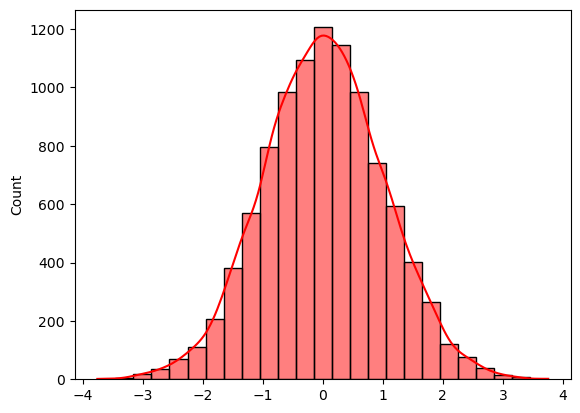

In [20]:
sns.histplot(normal_data, kde=True, color='r', bins=25)

# Q-Q plots
   * #### a graphical tool used to assess whether a dataset follows a specific theoretical distribution, such as the normal distribution.
   * #### It compares the quantiles of the observed data against the quantiles of the theoretical distribution.


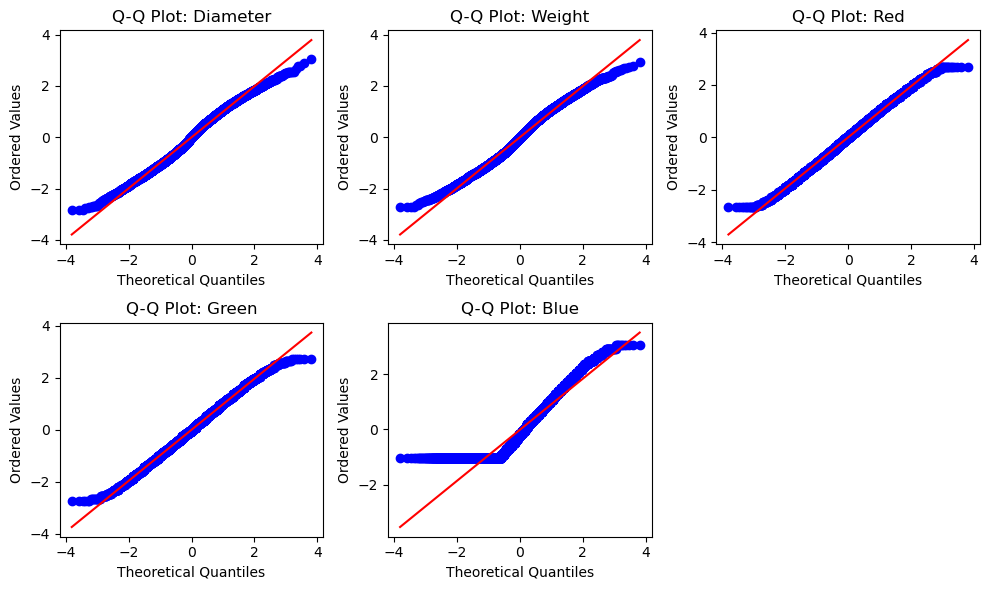

In [21]:
# plot the observed data on the y-axis and the expected quantiles (or percentiles) of the theoretical distribution on the x-axis.
# If the observed data points fall along a straight line, it suggests that the data is approximately normally distributed.

# Create Q-Q plots
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
stats.probplot(data['diameter'], dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.title('Q-Q Plot: Diameter')

plt.subplot(2, 3, 2)
stats.probplot(data['weight'], dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.title('Q-Q Plot: Weight')

plt.subplot(2, 3, 3)
stats.probplot(data['red'], dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.title('Q-Q Plot: Red')

plt.subplot(2, 3, 4)
stats.probplot(data['green'], dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.title('Q-Q Plot: Green')

plt.subplot(2, 3, 5)
stats.probplot(data['blue'], dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.title('Q-Q Plot: Blue')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Q-Q Plot: Diameter')

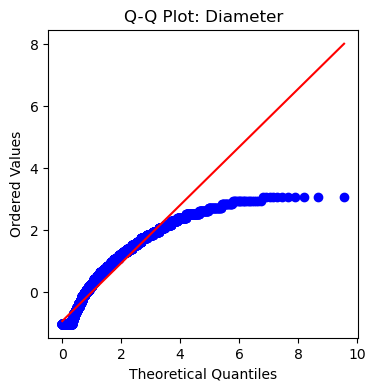

In [22]:
plt.figure(figsize=(4, 4))
plt.subplot(1, 1, 1)
stats.probplot(data['blue'], dist='expon', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.title('Q-Q Plot: Diameter')

## From above observations, We concluded that the Diameter, Weight, Red and Green are normally distributed "Gaussian distribution" <br/> But Blue is .....

************************************************************

# Distribution of data after standarization and removing Outliers

<Axes: >

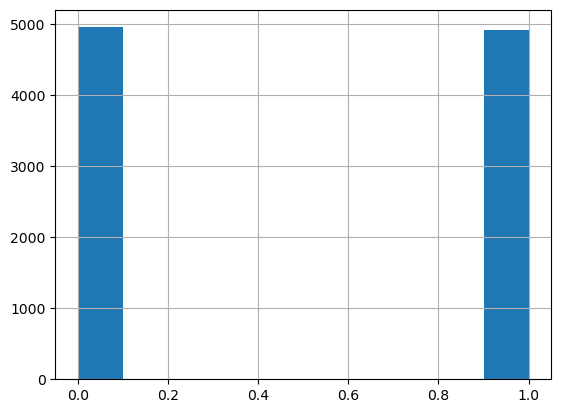

In [23]:
data["name"].hist()

<Axes: xlabel='blue', ylabel='Count'>

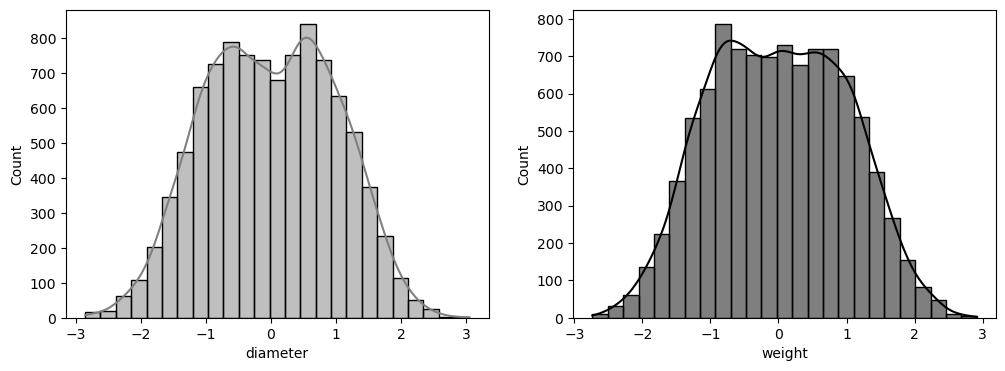

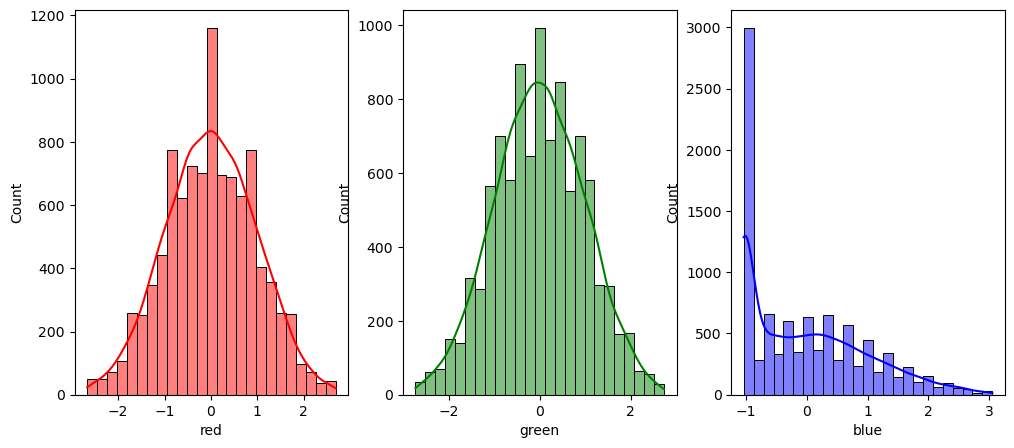

In [24]:
# distribution of data after standarization

# Create subplots with 1 row and 2 columns for the first figure
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Create subplots with 1 row and 3 columns for the second figure
fig, axs2 = plt.subplots(1, 3, figsize=(12, 5))

# Plot histogram of the 'diameter' feature with kernel density estimation
sns.histplot(data, x="diameter", kde=True, color='grey', ax=axs[0], bins=25)

# Plot histogram of the 'weight' feature with kernel density estimation
sns.histplot(data, x="weight", kde=True, color='black', ax=axs[1], bins=25)

# Plot histogram of the 'red' feature with kernel density estimation
sns.histplot(data, x="red", kde=True, color='r', ax=axs2[0], bins=25)

# Plot histogram of the 'green' feature with kernel density estimation
sns.histplot(data, x="green", kde=True, color='green', ax=axs2[1], bins=25)

# Plot histogram of the 'blue' feature with kernel density estimation
sns.histplot(data, x="blue", kde=True, color='b', ax=axs2[2], bins=25)

# Conditional probability

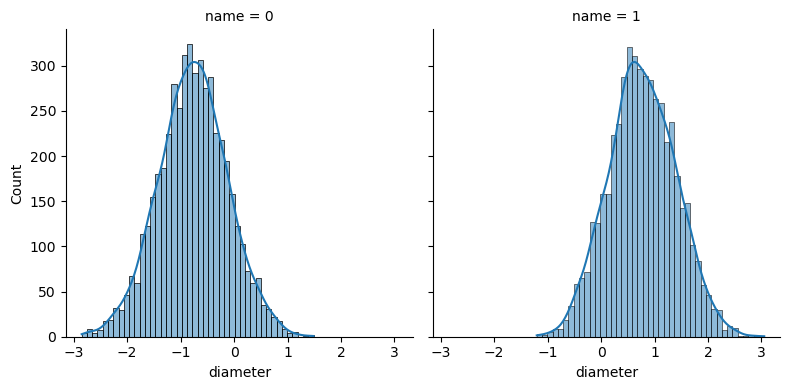

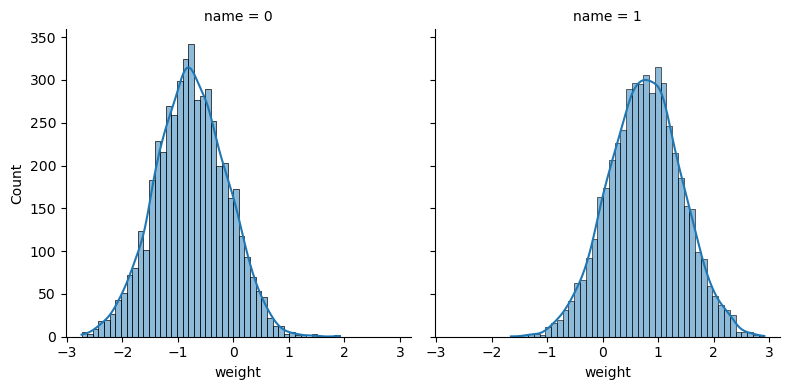

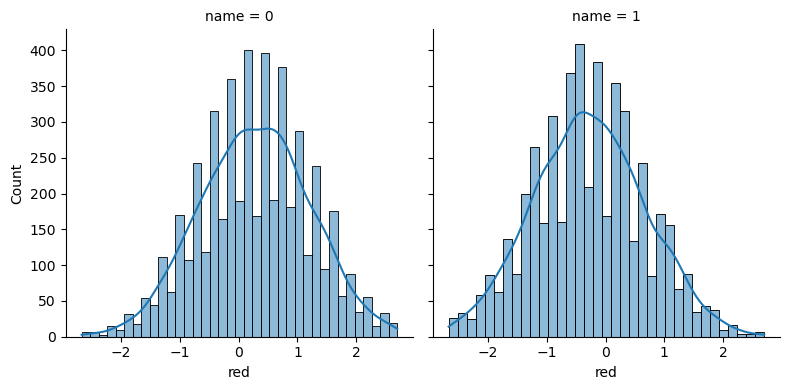

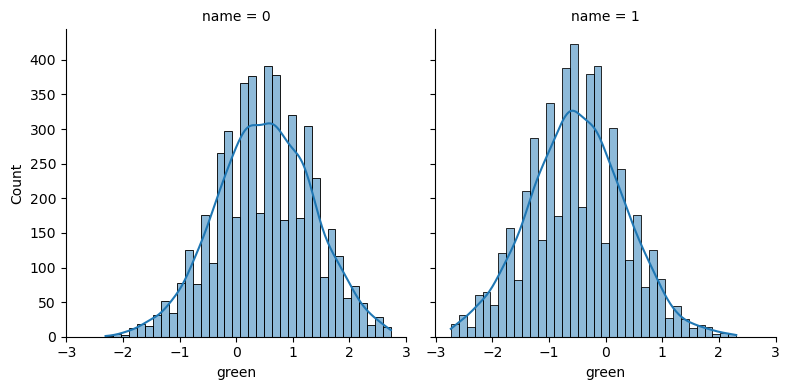

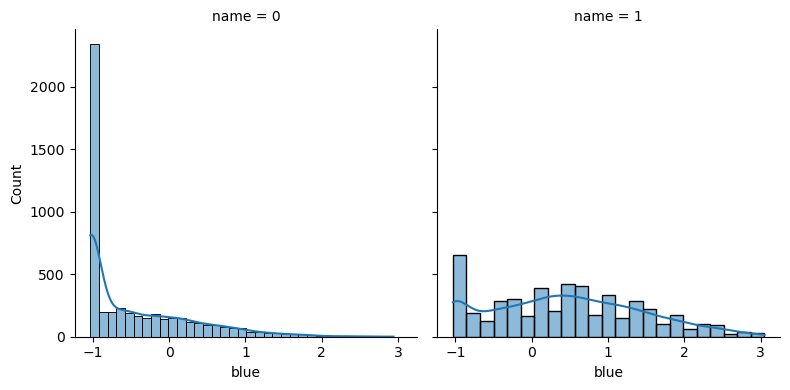

In [25]:
features = data.columns[1:]  # Select all column names except the first column
target_col = 'name'

# Iterate over each feature
for feature in features:
    # Create a FacetGrid object with target_col as the column variable and height=4 for subplot height
    g = sns.FacetGrid(data, col=target_col, height=4)
    # Plot a histogram with kernel density estimate for the current feature in the FacetGrid
    g.map(sns.histplot, feature, kde=True)
    # Display the plot
    plt.show()


***************************************************

## Split data into training data and testing data

In [26]:
# Splitting the data into features (X) and labels (y)
X = data.drop(['name'], axis=1)
X = np.asarray(X).astype(np.float64)
y = (data['name'])
y = np.asarray(y).astype(np.float64)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41, shuffle = True)
# print(y_test.value_counts())

# Implementation of the Naïve Bayes classifier from scratch.

## $$ P(Y|X) = \frac{{P(X|Y) \cdot P(Y)}}{{P(X)}} $$
### Where $P(Y|X)$ is **Posterior**, $P(X|Y)$ is **likehood** and $P(Y)$ is **prior**

### 1. Calculate $P(Y=y)$ for all possible $y$ values
### 2. Calculate $P(X=x|Y=y)$ using Gaussian distribution.
### 3. Calculate $ P(X=x_1|Y=y) P(X=x_2|Y=y)...P(X=x_n|Y=y) \cdot P(Y=y) $

#### for all $y$ and find the maximum and, $x_1, x_2, ....,x_n $ are features

In [27]:
class NaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Calculate mean, variance, and prior for each class
        self.class_mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self.class_variance = np.zeros((n_classes, n_features), dtype=np.float64)
        self.class_priors = np.zeros(n_classes, dtype=np.float64)

        for idx, target_class in enumerate(self.classes):
            # Select samples belonging to the current class
            X_c = X[y == target_class]

            # Calculate mean and variance for the current class
            self.class_mean[idx, :] = X_c.mean(axis=0)
            self.class_variance[idx, :] = X_c.var(axis=0)

            # Calculate prior probability for the current class
            self.class_priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # Calculate posterior probability for each class
        for idx, target_class in enumerate(self.classes):
            prior = np.log(self.class_priors[idx])

            # Calculate log-likelihood using Gaussian probability density function
            log_likelihood = np.sum(np.log(self._pdf(idx, x)))

            # Calculate posterior probability by adding prior and log-likelihood
            posterior = log_likelihood + prior
            posteriors.append(posterior)

        # Return the class with the highest posterior probability
        return self.classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        class_mean = self.class_mean[class_idx]
        class_variance = self.class_variance[class_idx]

        # Calculate the Gaussian probability density function
        numerator = np.exp(-((x - class_mean) ** 2) / (2 * class_variance))
        denominator = np.sqrt(2 * np.pi * class_variance)
        return numerator / denominator

## Test model

In [28]:
if __name__ == "__main__":
    # Create NaiveBayes object
    nb = NaiveBayes()

    # Fit the Naive Bayes classifier using training data
    nb.fit(X_train, y_train)

    # Predict the labels for test data
    y_pred = nb.predict(X_test)

    # Calculate and print the accuracy of Naive Bayes classification
    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy * 100

    print("Naive Bayes classification accuracy:", accuracy(y_test, y_pred))


Naive Bayes classification accuracy: 92.40121580547113


***************************************************

# NB classifier from sklearn package "GaussianNB"

In [29]:
# Create Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fit the classifier using training data
gnb.fit(X_train, y_train)

GaussianNB()

In [30]:
# Predict labels for the test data
predicted = gnb.predict(X_test)

# Calculate and print the accuracy of Gaussian Naive Bayes classification
accuracy = accuracy_score(predicted, y_test) * 100
print("Accuracy using Gaussian Naive Bayes: {}%".format(accuracy))

Accuracy using Gaussian Naive Bayes: 92.40121580547113%


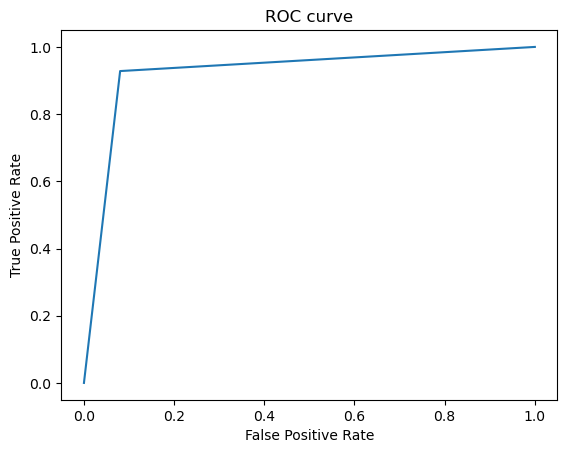

AUC value is 0.9239483994973016


In [31]:
# Compute ROC curve and AUC
fpr, tpr, threshold = roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.show()

# Calculate and print the AUC value
auc_value = auc(fpr, tpr)
print("AUC value is {}".format(auc_value))

***************************************************

## $$ \text {Method 2}$$

#  Simple Neural Network-based (NN) classifier.
The classification method used in the given code is a basic implementation of a feedforward neural network with a single hidden layer<br/> and softmax activation at the output layer. It can be considered a simple neural network-based classifier.

## Split data into training data and testing data

In [32]:
# Splitting the data into features (X) and labels (y)
X = data.drop(['name'], axis=1)
X = np.asarray(X).astype(np.float64)
y = (data['name'])
y = np.asarray(y).astype(np.float64)
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41, shuffle = True)

## Transform data into Tensors

In [33]:
# Convert training and validation data to tensors
X_train, y_train = tc.tensor(X_train), tc.tensor(y_train)
X_valid, y_valid = tc.tensor(X_test), tc.tensor(y_test)

from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the labels of training and validation data
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)

# Convert encoded labels to one-hot vectors
y_train_one_hot = tc.nn.functional.one_hot(tc.tensor(y_train_encoded), num_classes=2)
y_valid_one_hot = tc.nn.functional.one_hot(tc.tensor(y_valid_encoded), num_classes=2)

# Generating weights and biases

In [34]:
# SEED is used to make sure that generated data is consistent each time
tc.manual_seed(seed=5)

# Initialize the weight tensor
w = tc.randn(size=(2, 5))
w = w.to(tc.float64)
w.requires_grad = True
w.retain_grad()

tc.manual_seed(seed=5)

# Initialize the bias tensor
b = tc.randn(size=(1, 2))
b = b.to(tc.float64)
b.requires_grad = True
b.retain_grad()


## forward path and activation function

In [35]:
def predict(x):
    # Compute the linear transformation of input x using weight tensor w and bias tensor b
    a = x @ w.t() + b

    # Apply softmax activation function along dimension 1 (columns) to get the probabilities
    return tc.softmax(a, dim=1)

## prediction error

In [36]:
def loss_torch(x, y):
    # Perform forward pass to obtain predicted probabilities
    y_hat = predict(x)

    # Compute the cross-entropy loss between predicted probabilities (y_hat) and target labels (y)
    # Note: y should be of type long to match the expected input type for cross_entropy
    return tc.nn.functional.cross_entropy(y_hat, y.long())

## Backpropagation and Optimization loop

In [37]:
EPOCHS = 5000
DELTA = 0.01 
train_ls , valid_ls = [], []

# Perform training for the specified number of epochs
for _ in range(EPOCHS):
    # Compute the loss and perform backpropagation
    curr_train_ls = loss_torch(X_train , y_train)
    curr_train_ls.backward()
    train_ls.append(curr_train_ls.data) 

    # Disable gradient tracking and perform validation
    with tc.no_grad():
        # Convert y_test to a PyTorch tensor of type long
        y_valid_tensor = tc.tensor(y_test).long()

        # Compute the validation loss
        curr_valid_ls = loss_torch(X_valid, y_valid_tensor)
        valid_ls.append(curr_valid_ls.data)

        # Update weights and biases using gradient descent
        w -= DELTA * w.grad.data
        b -= DELTA * b.grad.data

        # Reset gradients to zero
        w.grad.zero_()
        b.grad.zero_()

## plot loss of data to indicate convergence 

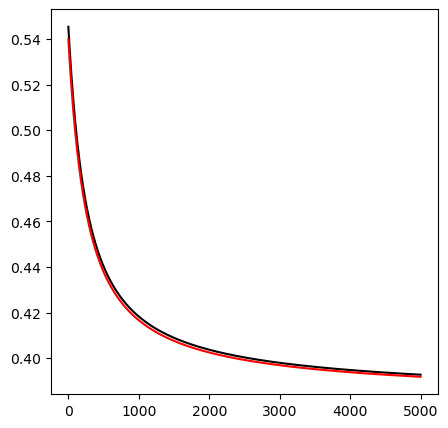

In [38]:
fig = figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(train_ls , "k")
ax.plot(valid_ls , "r")

## Calculate accuracy of model

In [39]:
def calculate_accuracy(x, y):
    # Make predictions using the predict function
    y_pred = predict(x)

    # Get the predicted labels by finding the maximum values along the second dimension
    _, predicted_labels = tc.max(y_pred, dim=1)

    # Count the number of correctly predicted labels
    correct = (predicted_labels == y).sum().item()

    # Get the total number of samples
    total = y.size(0)

    # Compute the accuracy
    accuracy = correct / total * 100
    return accuracy

# Calculate accuracy for training set
train_accuracy = calculate_accuracy(X_train, y_train)
print("Training Accuracy: {:.2f}%".format(train_accuracy))

# Calculate accuracy for validation set
valid_accuracy = calculate_accuracy(X_valid, y_valid)
print("Validation Accuracy: {:.2f}%".format(valid_accuracy))


Training Accuracy: 92.94%
Validation Accuracy: 92.65%
